# Title

In [18]:
import numpy as np  
#import numpy.random as random  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


## Part 1 - Travelling Salesman

In [2]:
#section-specific modules

import json
import copy

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

map = mpimg.imread("map.png")  

In [3]:
# List of 30 US state capitals and corresponding coordinates on the map

with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)    
capitals_list = list(capitals.items())

capitals_list = [(c[0], tuple(c[1])) for c in capitals_list]



In [19]:
def coord(path):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coord = path
        return coord

def coords(path):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*path)
        return coords
    
def show_path(path_, starting_city, w=35, h=15):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    path=coords(path_) 
    x, y = list(zip(*path))
    
    _, (x0, y0) = starting_city
    
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    

[('Oklahoma City', (392.8, 356.4)), ('Montgomery', (559.6, 404.8)), ('Salt Lake City', (204.0, 243.2))]


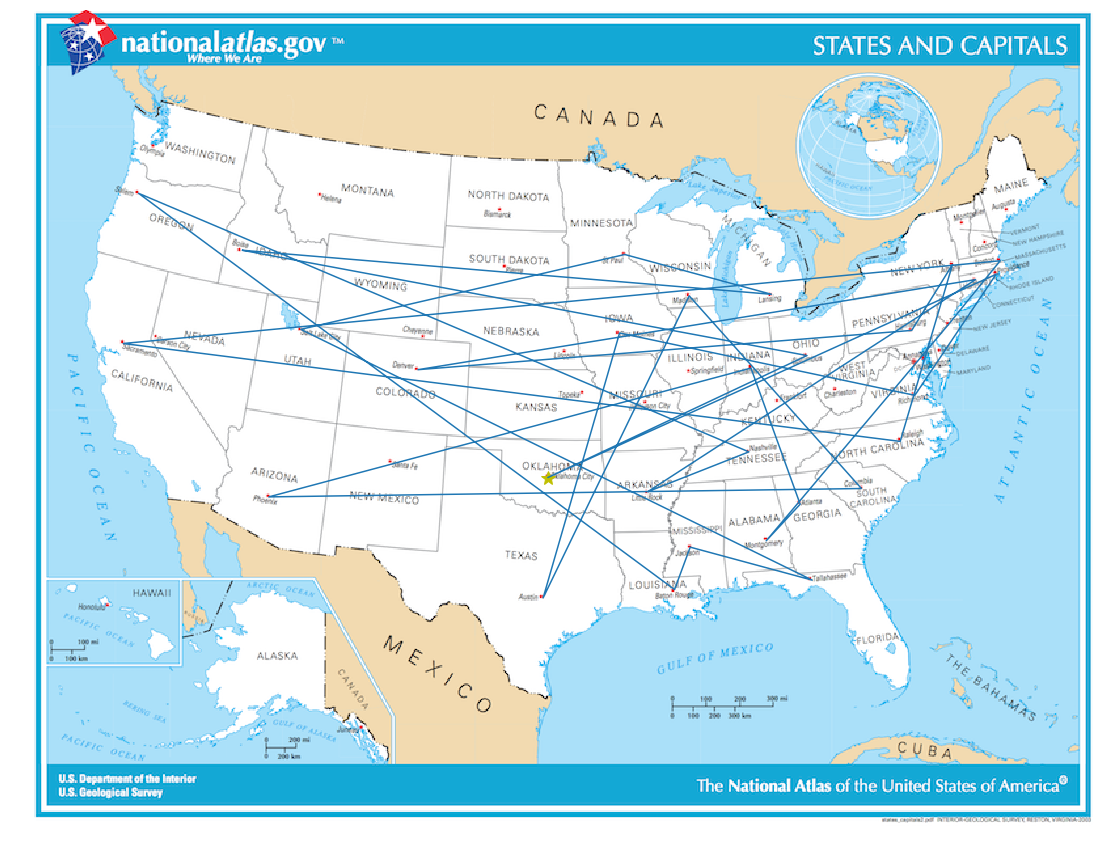

In [57]:
# Test with an arbitrary path

path = [capitals_list[0],capitals_list[1],capitals_list[4]]

print(path)

show_path(getPath(len(capitals_list)),capitals_list[0])

In [24]:

#Define a temperature schedule
def temp(t, a = .95, t_0 = 1e8):
    return (a ** t) * t_0

#get a random starting path
def getPath(n=8):

    test_cities = []
    mod_capitals = list(capitals_list)

    for i in range(0,n):
        test_cities.append(mod_capitals.pop(np.random.randint(len(mod_capitals))))

    return test_cities

### Pairwise exchange

In [39]:
def exchange(path):
    #choose two random points, and reverse the path between them - exclude the first and last item though, to avoid
    #problems with thr path not being cyclic anymore
    
    a = 1 + np.random.randint(len(path) - 2)
    b = a + np.random.randint(1, len(path) - a)
    
    a = 1 + np.random.randint(len(path)-2)
    b = a + np.random.randint(1, len(path) - a)
    return path[:a] + path[b:a-1:-1] + path [b+1:]

pathA = getPath()
#show_path(pathA,pathA[0])
print(pathA)
print('\n')
print(exchange(pathA))
#show_path(pathA,pathA[0])

[('Salem', (80.0, 139.2)), ('Atlanta', (585.6, 376.8)), ('Sacramento', (68.4, 254.0)), ('Salt Lake City', (204.0, 243.2)), ('Boise', (159.6, 182.8)), ('Columbia', (632.4, 364.8)), ('Tallahassee', (594.8, 434.8)), ('Austin', (389.2, 448.4))]


[('Salem', (80.0, 139.2)), ('Atlanta', (585.6, 376.8)), ('Salt Lake City', (204.0, 243.2)), ('Sacramento', (68.4, 254.0)), ('Boise', (159.6, 182.8)), ('Columbia', (632.4, 364.8)), ('Tallahassee', (594.8, 434.8)), ('Austin', (389.2, 448.4))]


In [22]:
def getLength(path):
    total = 0
    cPath = [i for i in coords(path)]
    cPath.append(coord(path[0]))
    
    for i in range(len(cPath) - 1):
        total += np.sum((np.array([j for j in cPath[i]]) - np.array([j for j in cPath[i+1]]))**2) ** 0.5
    
    return total

print(getLength(pathA))


2211.6207894205577


### Optimizing the path length

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


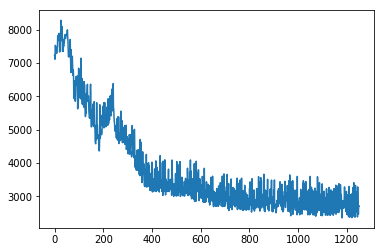

final distance is: 0.0


In [46]:
def optimize(initialPath, tStep=200, alpha=0.97,T=1000):
    distances = [getLength(initialPath)]
    paths = [initialPath]
    distance = distances[0]
    for t in np.arange(tStep):
        newPath = exchange(list(initialPath))
        
        oldD = distance
        newD = getLength(newPath)
        
        if np.exp((oldD - newD)/temp(t,alpha,T)) > np.random.random():
            initialPath = newPath
            distance = newD
        
        distances.append(newD)
        paths.append(newPath)
        
    
    return paths, distances


best, distanceList = optimize(getPath(len(capitals_list)), 1250, alpha=0.99,T=1000)

plt.plot(np.arange(len(distanceList)), distanceList)
plt.show()
#show_path(best, best[0])
#plt.show()
print("final distance is: {}".format(np.min(dist)))

### Runtime improvements

In [44]:
# Currently, need to calculate the distance between every city, on every iteration - better to cache the distances,
# and label cities as an index.

def getIndexPath(n=8):
    # returns numbers from 0 to n in a random order
    path = []
    mod_capitals = list(range(n))

    for i in range(0,n):
        path.append(mod_capitals.pop(np.random.randint(len(mod_capitals))))

    return path

# Build a matrix of distances between cities, where dist[a][b] is the distance from a to b

dist = [[np.sum((np.array([j for j in a]) - np.array([j for j in b]))**2) ** 0.5 for b in coords(capitals_list)]for a in coords(capitals_list)]

print(dist[1][3]) # corresponds to the distance between captials_list[1] and [3]

# It's also useful to define a new function to calculate a length for an index path

def indexPathLength(path):
    #print(path)
    mask = np.zeros(shape=(len(path),len(path)))
    path = np.append(path, path[0])
    #Interesting property about numpy arrays: we can index using another array to select many elements at once
    mask[path[:-1], path[1:]] = 1
    return np.einsum('ij,ij',mask,dist) #multiplies the mask and dist matrices pairwise, and sums the result

print(getIndexPath(len(capitals_list)))


216.02703534511596
[14, 4, 7, 13, 8, 24, 17, 27, 21, 2, 26, 19, 1, 22, 18, 29, 28, 20, 3, 15, 23, 11, 6, 16, 12, 5, 25, 0, 9, 10]


In [50]:
# Instead of recalculating the path distance, it's more efficient to just modify the previous one:
# this takes 4 operations, rather than len(path) - however, when we exchange, we now need to know what
# indices were switched

def exchangeAndReturnPairs(path):
    #choose two random points, and reverse the path between them - exclude the first and last item though, to avoid
    #problems with thr path not being cyclic anymore
    
    a = 1 + np.random.randint(len(path) - 2)
    b = a + np.random.randint(1, len(path) - a)
    
    a = 1 + np.random.randint(len(path)-2)
    b = a + np.random.randint(1, len(path) - a)
    return path[:a] + path[b:a-1:-1] + path [b+1:], a, b

# myPath = getIndexPath()
# print(myPath)
# print(exchange(myPath))

def optimizeFast(initialPath, tStep=200, alpha=0.97,T=1000):
    distance = indexPathLength(initialPath)
    distances = [distance]
    paths = [initialPath]
    numCities = len(initialPath)
    
    for t in np.arange(tStep):
        newPath, a, b = exchangeAndReturnPairs(list(initialPath))
        
        oldD = distance
        mask = np.zeros(shape=(numCities,numCities))
        # subtract the two segments we deleted, and add the two new ones
        mask[[initialPath[a],initialPath[b]],[initialPath[(a-1)%numCities],initialPath[(b+1)%numCities]]] = -1
        mask[[initialPath[b],initialPath[a]],[initialPath[(a-1)%numCities],initialPath[(b+1)%numCities]]] = 1
        newD = oldD + np.einsum('ij,ij',mask,dist)
        
        if np.exp((oldD - newD)/temp(t,alpha,T)) > np.random.random():
            initialPath = newPath
            distance = newD
        
        distances.append(newD)
        paths.append(newPath)
        
    
    return paths, distances


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


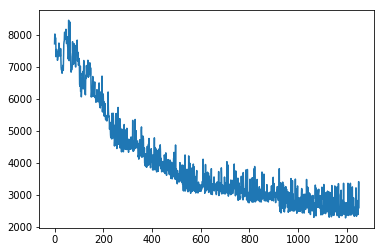

final distance is: 2280.0044475726413


In [60]:
pathList, distanceList = optimizeFast(getIndexPath(len(capitals_list)), 1250, alpha=0.99,T=1000)

plt.plot(np.arange(len(distanceList)), distanceList)
plt.show()
#show_path(best, best[0])
#plt.show()
print("final distance is: {}".format(np.min(distanceList)))

### Speed comparison

In [54]:
%timeit pathList, distanceList = optimize(getPath(len(capitals_list)), 1250, alpha=0.99,T=1000)

725 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


In [55]:
%timeit pathList, distanceList = optimizeFast(getIndexPath(len(capitals_list)), 1250, alpha=0.99,T=1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


195 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Interfacing with the solver

In [76]:
def shortestPath(initialPath, iterations=20, tstep=1250, alpha=0.98, T=1000, silent=False):
    best=initialPath
    distance=indexPathLength(initialPath)
    
    for _ in range(iterations):
        newPaths, newDistances = optimizeFast(initialPath,tstep,alpha,T)
        
        runBestIndex = np.argmin(newDistances)
        if not silent : print("run #{}, best distance:{}".format(_+1,newDistances[runBestIndex]))
        if newDistances[runBestIndex] < distance :
            distance = newDistances[runBestIndex]
            best = newPaths[runBestIndex]
        
    return best, distance

best, distance = shortestPath(getIndexPath(len(capitals_list)), 100, silent=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


Distance is 2185.363886644245


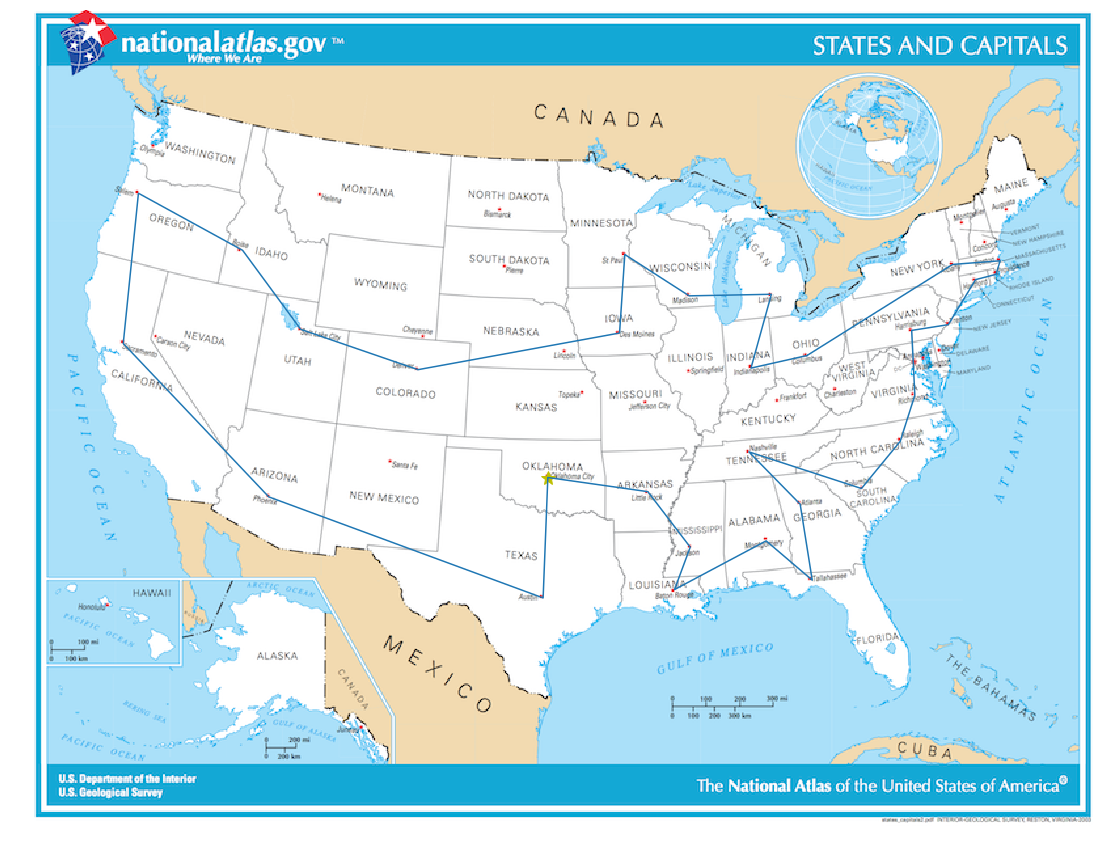

In [75]:
show_path(np.array(capitals_list)[best],capitals_list[0])
print("Distance is {}".format(distance))

# Part 2 - Tacoma bridge

In [77]:
# Useful constants

tstart=0
tend=100

d=0.01
a=1
M=2500
K=10000
l=6

In [78]:
# implement a discrete coupled diffeq solver

def tacoma(dt=0.01, cromer=False, y_init = 0.0, theta_init = 0.0, z_init = 0.0, gamma_init = 0.0, eqs = lambda x : x):

    # Create the variables to store our results
    times=np.arange(tstart, tend+dt, dt)  # Create the array of model times
    Nt=len(times)                         # Number of time-steps
    y=np.zeros(Nt)                   
    theta=np.zeros(Nt)                   
    z=np.zeros(Nt) 
    gamma=np.zeros(Nt) 

    # Set our initial conditions
    y[0] = y_init
    theta[0] = theta_init
    z[0] = z_init
    gamma[0] = gamma_init
  


    # Loop over all of our times and integrate the model
    for n in range(Nt-1):
        #Next step
        
        x_new = eqs([y[n], z[n], theta[n], gamma[n], times[n]])


        # Time-step the angle. If we are using 'Taylor' or 'Cromer"
        z[n+1] = z[n] + x_new[1] * dt
        gamma[n+1] = gamma[n] + x_new[3] * dt
        
        if cromer:
            
            y[n+1] = y[n] + z[n+1] * dt
            theta[n+1] = theta[n] + gamma[n+1] * dt
        
        else:
            
            y[n+1] = y[n] + z[n] * dt
            theta[n+1] = theta[n] + gamma[n] * dt
    return times, theta, y

In [79]:
def forceModel(x):
    # x is a vector of the form [y, y', theta, theta']
    # want to return the respective derivatives - [y', y'', theta', theta'']
    
    y = x[0]
    y_1 = x[1]
    theta = x[2]
    theta_1 = x[3]
    
    #these are the forces    
    y_2 = -d * y_1 - (K/M * (y - l * np.sin(theta)) + K/M * (y + l * np.sin(theta)))
    
    theta_2 = -d * theta_1 + 3 * np.cos(theta) / l * (K/M * (y - l * np.sin(theta)) - K/M * (y + l * np.sin(theta)))
    
    #we already have y_1 and theta_1
    
    return [y_1, y_2, theta_1, theta_2]

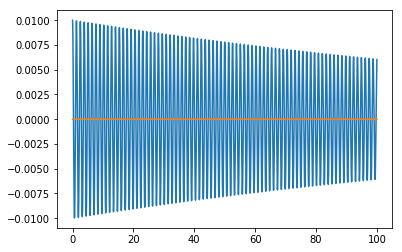

In [81]:
# Run the solver

times, theta, y = tacoma(cromer=True, theta_init = 0.01, eqs = forceModel)

plt.plot(times, theta)
plt.plot(times, y)

plt.show()

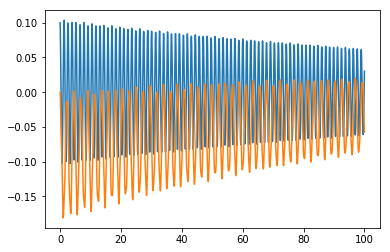

In [82]:
def betterForceModel(x):
    # x is a vector of the form [y, y', theta, theta']
    # want to return the respective derivatives - [y', y'', theta', theta'']
    
    y = x[0]
    y_1 = x[1]
    theta = x[2]
    theta_1 = x[3]
    
    #these are the forces    
    y_2 = -d * y_1 - K/(M*a) * (np.exp(a * (y - l * np.sin(theta))) - 1 + np.exp(a * (y + l * np.sin(theta))) - 1)
    
    theta_2 = -d * theta_1 + 3 * np.cos(theta) / l * K / (M * a) * ( np.exp(a * (y - l * np.sin(theta))) - np.exp(a * (y + l * np.sin(theta))))
    #we already have y_1 and theta_1
    
    return [y_1, y_2, theta_1, theta_2]

times, theta, y = tacoma(cromer=True, theta_init = 0.1, y_init = 0.0, eqs = betterForceModel)

plt.plot(times, theta)
plt.plot(times, y)

plt.show()

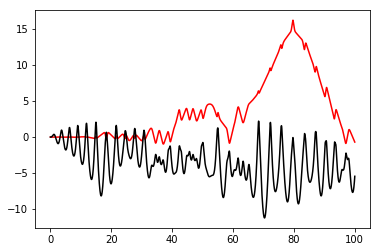

In [83]:
def windForceModel(x, w = 3, A = 1):
    # x is a vector of the form [y, y', theta, theta', time]
    # want to return the respective derivatives - [y', y'', theta', theta'']
    
    y = x[0]
    y_1 = x[1]
    theta = x[2]
    theta_1 = x[3]
    
    #these are the forces    
    y_2 = -d * y_1 - K/(M*a) * (np.exp(a * (y - l * np.sin(theta))) - 1 + np.exp(a * (y + l * np.sin(theta))) - 1)
    
    #add the wind component
    y_2 += A * np.sin(w * x[4])
    
    theta_2 = -d * theta_1 + 3 * np.cos(theta) / l * K / (M * a) * ( np.exp(a * (y - l * np.sin(theta))) - np.exp(a * (y + l * np.sin(theta))))
    #we already have y_1 and theta_1
    
    return [y_1, y_2, theta_1, theta_2]




times, theta, y = tacoma(cromer=True, theta_init = 0.01, eqs = lambda x : windForceModel(x, w = 2.343434, A =2))

plt.plot(times, theta, 'r')
plt.plot(times, y, 'k')

plt.show()

Resonance for theta occurs at: 2.3434343434343434


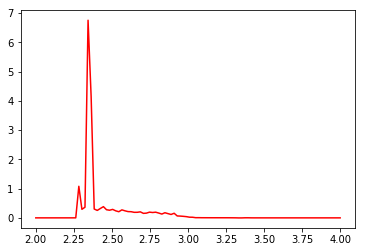

Resonance for Y occurs at: 2.3434343434343434


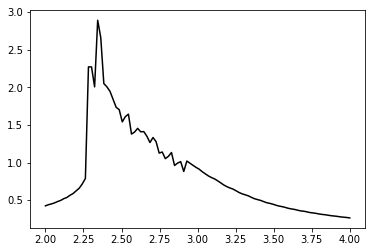

In [84]:
# Note - this takes a while to run

rmsY = []
rmsT = []

w_array = np.linspace(2,4,100)

for w in w_array:
    times, theta, y = tacoma(cromer=True, theta_init = 0.01, eqs = lambda x : windForceModel(x, w=w, A =2))
    
    rmsY.append(np.std(y))
    rmsT.append(np.std(theta))
    
#     rmsY.append(np.sqrt(np.mean(y ** 2)))
#     rmsT.append(np.sqrt(np.mean(theta ** 2)))

#plt.plot(w_array, rmsY,'k')
plt.plot(w_array, rmsT,'r')
print("Resonance for theta occurs at: {}".format(w_array[np.argmax(rmsT)]))
plt.show()

plt.plot(w_array, rmsY,'k')
print("Resonance for Y occurs at: {}".format(w_array[np.argmax(rmsY)]))
plt.show()

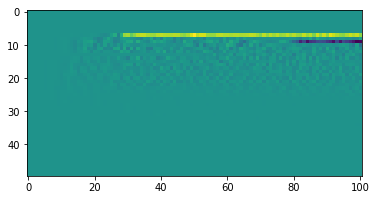

In [91]:
#heatmap with theta(t,w)

plt.imshow([tacoma(cromer=True, theta_init = 0.01, eqs = lambda x : windForceModel(x, w=w, A =2))[1][::100] for w in np.linspace(2,4,50)])

plt.show()

frequency = 2.0, RMS value for theta= 0.005776379670023036


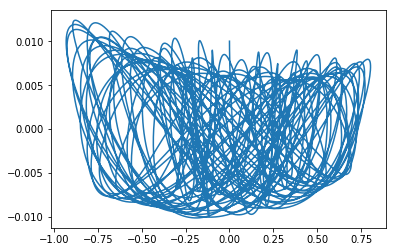

frequency = 2.5, RMS value for theta= 0.24939620599811935


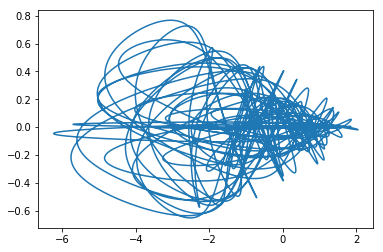

frequency = 3.0, RMS value for theta= 0.03558421183024278


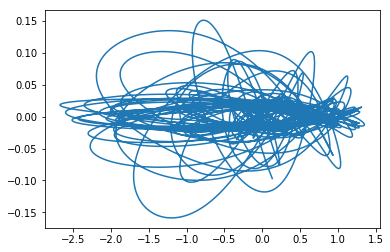

frequency = 3.5, RMS value for theta= 0.005761975596415069


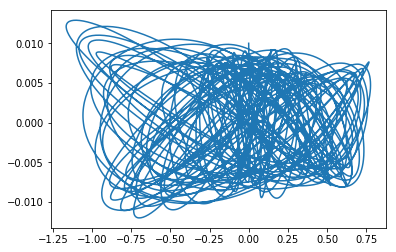

frequency = 4.0, RMS value for theta= 0.005750646400867286


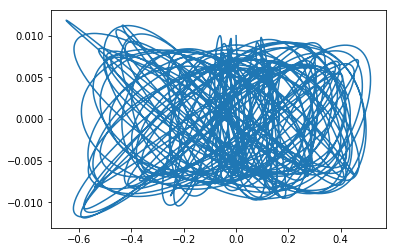

frequency = 2.3434343434343434, RMS value for theta= 6.7520554922088865


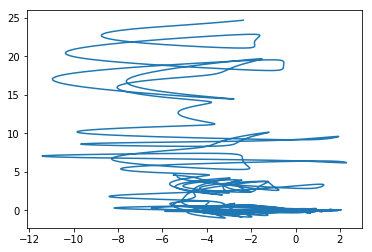

In [92]:
for w in np.linspace(2,4,5):
    times, theta, y = tacoma(cromer=True, theta_init = 0.01, eqs = lambda x : windForceModel(x, w=w, A =2))
    plt.plot(y,theta)
    print("frequency = {0}, RMS value for theta= {1}".format(w, np.std(theta)))
    plt.show()

    
w = 2.3434343434343434
times, theta, y = tacoma(cromer=True, theta_init = 0.01, eqs = lambda x : windForceModel(x, w=w, A =2))
plt.plot(y,theta)
print("frequency = {0}, RMS value for theta= {1}".format(w, np.std(theta)))
plt.show()


# Part 3 - Image compression